## Install dependencies

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !wget -q https://www.dropbox.com/s/g5t24we9gl5yk88/TimeSformer_divST_8x32_224_K400.pyth
!pip install -q simplejson einops timm scikit-learn tensorboard psutil einops
!pip install -q git+https://github.com/facebookresearch/fvcore
!git clone https://github.com/down-shift/TimeSformer.git
!pip install -q ./TimeSformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 700.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Cloning into 'TimeSformer'...
remote: Enumerating objects: 413, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 413 (delta 114), reused 85 (delta 80), pack-reused 246
Receiving objects: 100% (413/413), 340.18 KiB | 1.34 MiB/s, done.
Resolving deltas: 100% (191/191), done.
  Preparing metadata (setup.py) ... done


In [3]:
%mkdir rzd_video
%cd rzd_video
!wget https://lodmedia.hb.bizmrg.com/case_files/1051365/train_dataset_train.zip
!unzip -q train_dataset_train.zip
%cd ..

/content/rzd_video
--2023-11-11 09:07:50--  https://lodmedia.hb.bizmrg.com/case_files/1051365/train_dataset_train.zip
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 95.163.53.117
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|95.163.53.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839402160 (801M) [application/zip]
Saving to: ‘train_dataset_train.zip’

train_dataset_train 100%[===================>] 800.52M  10.9MB/s    in 70s     

2023-11-11 09:09:03 (11.4 MB/s) - ‘train_dataset_train.zip’ saved [839402160/839402160]

/content


## Import libraries and setup constants

In [5]:
import numpy as np
import cv2
import os
import torch

from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from timesformer.models.vit import TimeSformer


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 42
input_size = 224
CLASSES = dict([(i, cl) for i, cl in enumerate(sorted(os.listdir('/content/rzd_video/videos')))])
DATA_DIR = '/content/rzd_video/videos'

In [6]:
CLASSES

{0: 'cartwheel',
 1: 'catch',
 2: 'clap',
 3: 'climb',
 4: 'dive',
 5: 'draw_sword',
 6: 'dribble',
 7: 'fencing',
 8: 'flic_flac',
 9: 'golf',
 10: 'handstand',
 11: 'hit',
 12: 'jump',
 13: 'pick',
 14: 'pour',
 15: 'pullup',
 16: 'push',
 17: 'pushup',
 18: 'shoot_ball',
 19: 'sit',
 20: 'situp',
 21: 'swing_baseball',
 22: 'sword_exercise',
 23: 'throw'}

## Utils

In [8]:
def freeze(model, freeze_head=True):
    for name, param in model.named_parameters():
        if 'head' in name:
            param.requires_grad = freeze_head
        else:
            param.requires_grad = False
    return model

In [19]:
from IPython.display import clear_output


def show_history(epoch, history):
    clear_output()
    print(f'--- Epoch {epoch} ---')
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 3, 1)
    plt.title('Train loss graph')
    plt.plot(history['train_loss'])
    plt.grid()
    plt.subplot(2, 3, 2)
    plt.title('Val loss graph')
    plt.plot(history['val_loss'])
    plt.grid()
    plt.subplot(2, 3, 3)
    plt.title('Precision graph')
    plt.plot(history['precision'])
    plt.grid()
    plt.subplot(2, 3, 4)
    plt.title('Recall graph')
    plt.plot(history['recall'])
    plt.grid()
    plt.subplot(2, 3, 5)
    plt.title('F1-score graph')
    plt.plot(history['f1'])
    plt.grid()
    plt.subplot(2, 3, 6)
    plt.title('Accuracy graph')
    plt.plot(history['acc'])
    plt.grid()
    plt.show()
    print("\n--- Validation losses ---")
    print(f"\nAverage train loss: {np.mean(history['train_loss'])}, average test loss: {np.mean(history['val_loss'])}\n")
    print('--- Validation metrics ---')
    print(f"\nAccuracy: {history['acc'][-1]}, precision: {history['precision'][-1]}, recall: {history['recall'][-1]}, f1-score: {history['f1'][-1]}\n")


## Define dataset

In [10]:
def read_video(path, frames_num=8):
    frames = []
    cap = cv2.VideoCapture(path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    N = length//(frames_num)
    assert N > 0, 'Too many frames requested'
    current_frame = 0
    for i in range(length):
        ret, frame = cap.read(current_frame)
        if ret and i == current_frame and len(frames) < frames_num:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            current_frame += N
    cap.release()
    return frames

In [11]:
class VideoDataset(Dataset):
    def __init__(self, root, classes, num_frames, transform=None):
        self.num_frames = num_frames
        self.video_paths = []
        self.labels = []
        self.transform = transform
        for idx, c in classes.items():
            self.video_paths.extend([os.path.join(root, c, f) for f in os.listdir(os.path.join(root, c))])
            self.labels.extend([idx for _ in range(len(os.listdir(os.path.join(root, c))))])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        frames = read_video(self.video_paths[idx], frames_num=self.num_frames)
        # frames = np.array(vid.return_list(total_frames=self.num_frames))
        frames = torch.tensor(np.array(frames))
        if len(frames) != self.num_frames:
            print(f'len mismatch: {len(frames)} vs {self.num_frames}')
        if self.transform:
            frames = self.transform(frames)
        label = self.labels[idx]
        return (frames, label)

In [12]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: x / 255.),
    transforms.Lambda(lambda x: x.permute(3, 0, 1, 2)),  # (T, C, H, W)
    transforms.Lambda(lambda x: torch.nn.functional.interpolate(x, (224, 224))),
])

full_dataset = VideoDataset(root=DATA_DIR, classes=CLASSES, num_frames=4, transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size],
                                                           torch.Generator().manual_seed(SEED))

## Get dataloaders

In [13]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

## Download the pre-trained TimeSformer

In [15]:
model = TimeSformer(img_size=224, num_classes=len(CLASSES), num_frames=4, attention_type='divided_space_time')
model.load_state_dict(torch.load('/content/drive/MyDrive/Olymps/leadersofdigital/stavropol/timesformer_full_ep1_0.9036.pt'))
model = model.to(device)
dummy_video = torch.zeros(2, 3, 4, 224, 224).to(device) # (batch x channels x frames x height x width)

pred = model(dummy_video,)
pred.shape

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


torch.Size([2, 24])

## Prepare for training

In [ ]:
# # freeze model
# model = freeze(model)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

In [17]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5,
                              betas=(0.9, 0.999), weight_decay=0.01)

--- Epoch 9 ---


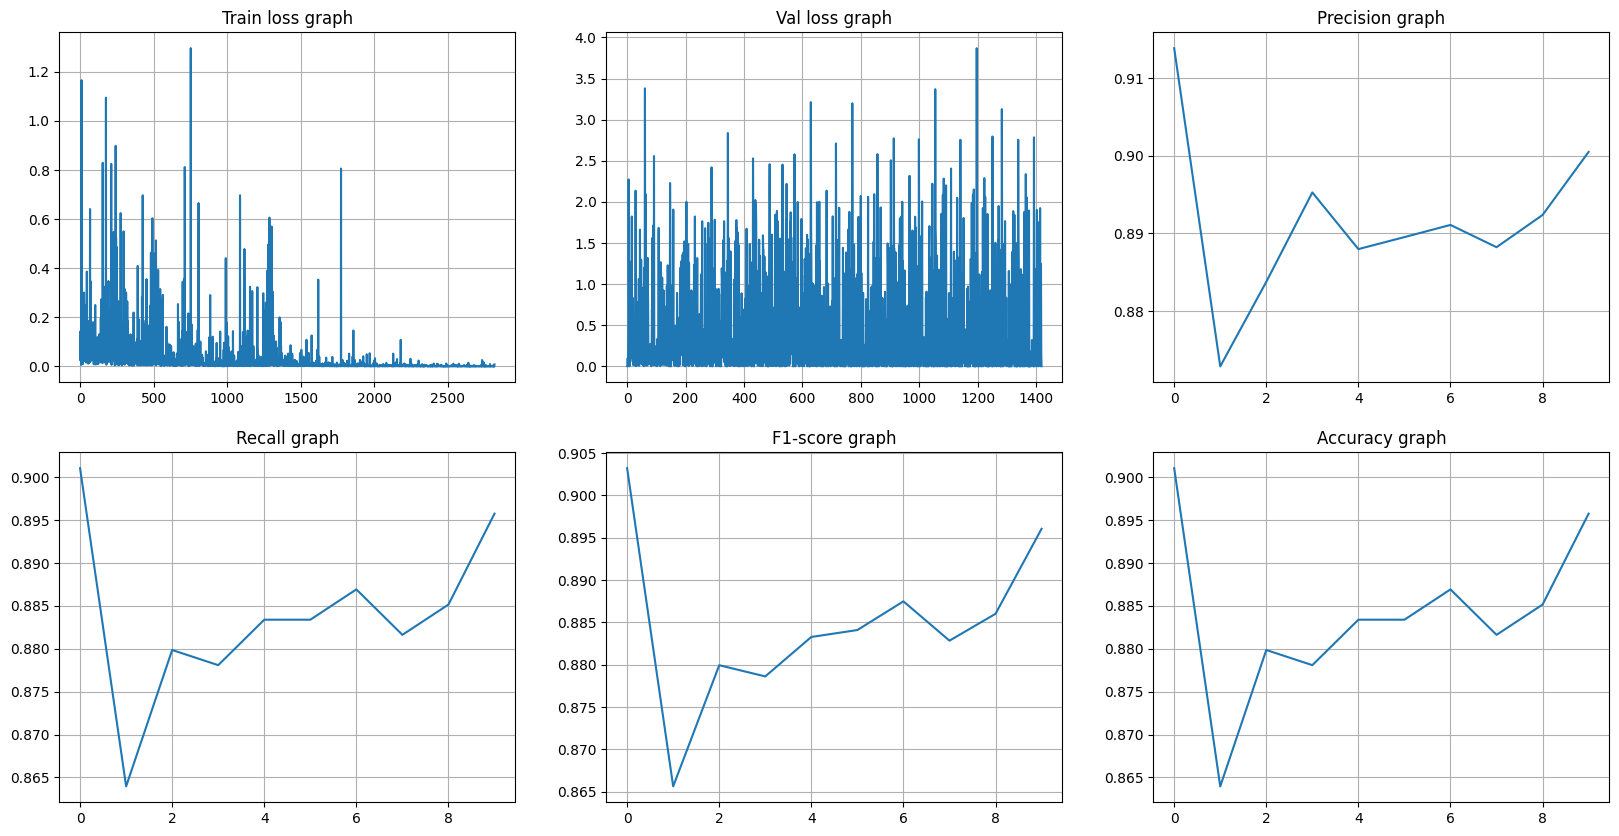


--- Validation losses ---

Average train loss: 0.030461744035976335, average test loss: 0.4591790306967391

--- Validation metrics ---

Accuracy: 0.8957597173144877, precision: 0.9004869295139919, recall: 0.8957597173144877, f1-score: 0.8960514703199863



In [20]:
history = {'train_loss': [], 'val_loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': []}

epochs = 10
best_loss = 0.9
best_f1 = 0.85

for epoch in range(epochs):
    print(f'--- Epoch {epoch} ---\n')

    print('Training...')
    # training loop
    model.train()
    progress_bar = tqdm(train_loader)
    train_loss, val_loss = 0, 0
    for id, (videos, labels) in enumerate(progress_bar):
        torch.cuda.empty_cache()
        videos = videos.to(device)
        labels = labels.to(device)
        torch.cuda.empty_cache()

        optimizer.zero_grad()
        out = model(videos)
        loss = criterion(out, labels)
        train_loss += loss.item()
        history['train_loss'].append(loss.item())
        progress_bar.set_postfix({'loss': loss.item()})
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()

    print('\nValidating...')
    # validation loop
    model.eval()
    progress_bar = tqdm(val_loader)
    preds, gt = [], []
    for id, (videos, labels) in enumerate(progress_bar):
        torch.cuda.empty_cache()
        videos = videos.to(device)
        labels = labels.to(device)
        torch.cuda.empty_cache()

        out = model(videos)
        torch.cuda.empty_cache()
        preds.extend(out.argmax(dim=1).tolist())
        gt.extend(labels.tolist())
        loss = criterion(out, labels)
        val_loss += loss.item()
        history['val_loss'].append(loss.item())
        progress_bar.set_postfix({'loss': loss.item()})
        torch.cuda.empty_cache()

    history['acc'].append(accuracy_score(preds, gt))
    history['f1'].append(f1_score(preds, gt, average='weighted'))
    history['precision'].append(precision_score(preds, gt, average='weighted'))
    history['recall'].append(recall_score(preds, gt, average='weighted'))

    # save weights
    if history['f1'][-1] > best_f1:
        print(f"New best model, f1_score: {history['f1'][-1]}")
        best_f1 = history['f1'][-1]
        torch.save(model.state_dict(), f"timesformer_full_ep{epoch}_{history['f1'][-1]:.4f}.pt")
        print('Saved to:', f"timesformer_ep{epoch}_{history['f1'][-1]:.4f}.pt")

    show_history(epoch, history)


In [32]:
class_res = {i: [0, 0] for i in range(len(CLASSES))}
class_ratios = {cls: 0 for _, cls in CLASSES.items()}

for i in range(len(gt)):
    class_res[gt[i]][0] += int(gt[i] == preds[i])
    class_res[gt[i]][1] += 1
for i, cls in CLASSES.items():
    class_ratios[cls] = class_res[i][0] / class_res[i][1]
class_ratios

{'cartwheel': 0.5333333333333333,
 'catch': 0.9090909090909091,
 'clap': 0.9,
 'climb': 1.0,
 'dive': 0.9642857142857143,
 'draw_sword': 0.7727272727272727,
 'dribble': 0.9354838709677419,
 'fencing': 0.9583333333333334,
 'flic_flac': 0.7391304347826086,
 'golf': 1.0,
 'handstand': 0.8571428571428571,
 'hit': 0.8666666666666667,
 'jump': 0.8461538461538461,
 'pick': 0.7368421052631579,
 'pour': 1.0,
 'pullup': 1.0,
 'push': 1.0,
 'pushup': 1.0,
 'shoot_ball': 0.9615384615384616,
 'sit': 0.7857142857142857,
 'situp': 1.0,
 'swing_baseball': 0.967741935483871,
 'sword_exercise': 0.9032258064516129,
 'throw': 0.6470588235294118}